# Compare the Model Performances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import numpy as np
import glob
import os

In [2]:
def concatenate_performance_files(pattern, output_file):
    files = glob.glob(pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {pattern}")
        return

    # Load and concatenate CSV files
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

    # Save combined CSV
    df.to_csv(output_file, index=False)
    print(f"Saved combined file to {output_file}")

concatenate_performance_files(
    pattern="*/outputs/*classification*performance_summary.csv",
    output_file="classification_performance_summary.csv"
)

concatenate_performance_files(
    pattern="*/outputs/*regression*performance_summary.csv",
    output_file="regression_performance_summary.csv"
)

Saved combined file to classification_performance_summary.csv
Saved combined file to regression_performance_summary.csv


In [3]:
reg_metrics = pd.read_csv('regression_performance_summary.csv')
class_metrics = pd.read_csv('classification_performance_summary.csv')

## Radar Plots

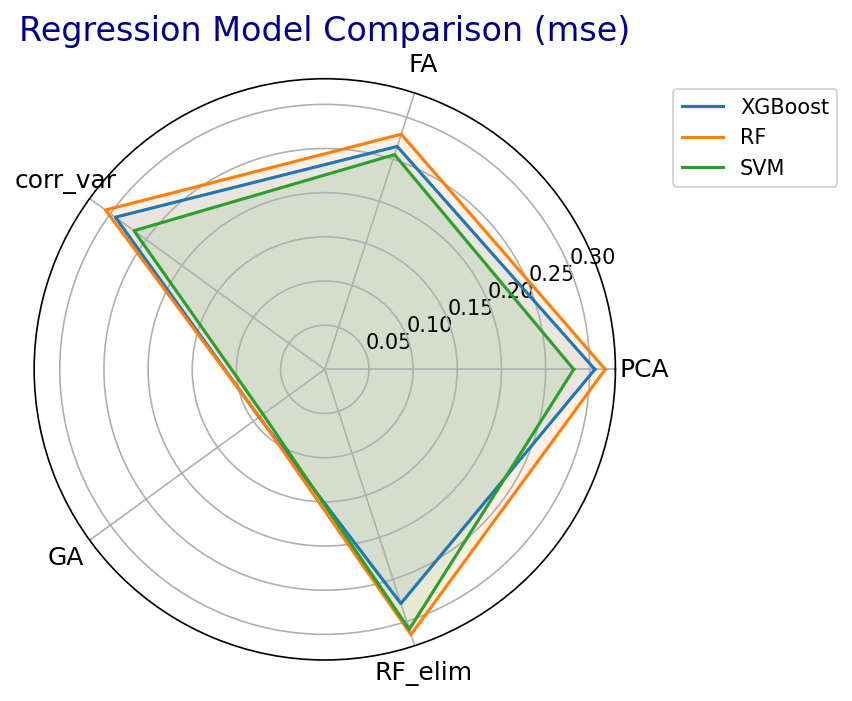

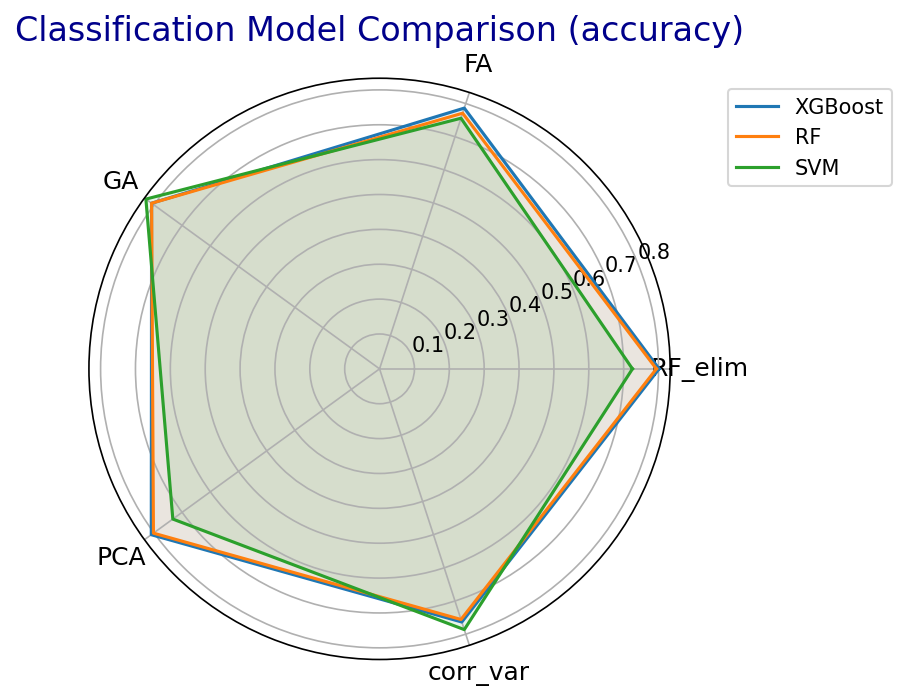

In [7]:
def plot_radar(df, metric, title):
    feature_methods = df['input_type'].unique()
    models = df['model_type'].unique()
    N = len(feature_methods)
    
    fig, ax = plt.subplots(figsize=(5, 6), subplot_kw=dict(polar=True), dpi=150)

    for model in models:
        subset = df[df['model_type'] == model]
        values = [subset.loc[subset['input_type'] == method, metric].mean() for method in feature_methods]
        
        # Handle empty cases if metric data is missing
        if any(pd.isna(values)):
            continue
        
        # Normalize MSE to reverse scale (lower is better)
        if metric == 'mse':
            values = [1 / v if v != 0 else 0 for v in values]
        
        # Close the radar chart loop
        values += values[:1]
        angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks([n / float(N) * 2 * pi for n in range(N)])
    ax.set_xticklabels(feature_methods, fontsize=12)
    ax.set_title(f'{title} ({metric})', size=16, color='darkblue')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.savefig(f"radar_plot_{metric}.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_radar(reg_metrics, 'mse', "Regression Model Comparison")
plot_radar(class_metrics, 'accuracy', "Classification Model Comparison")

## Bar Plots

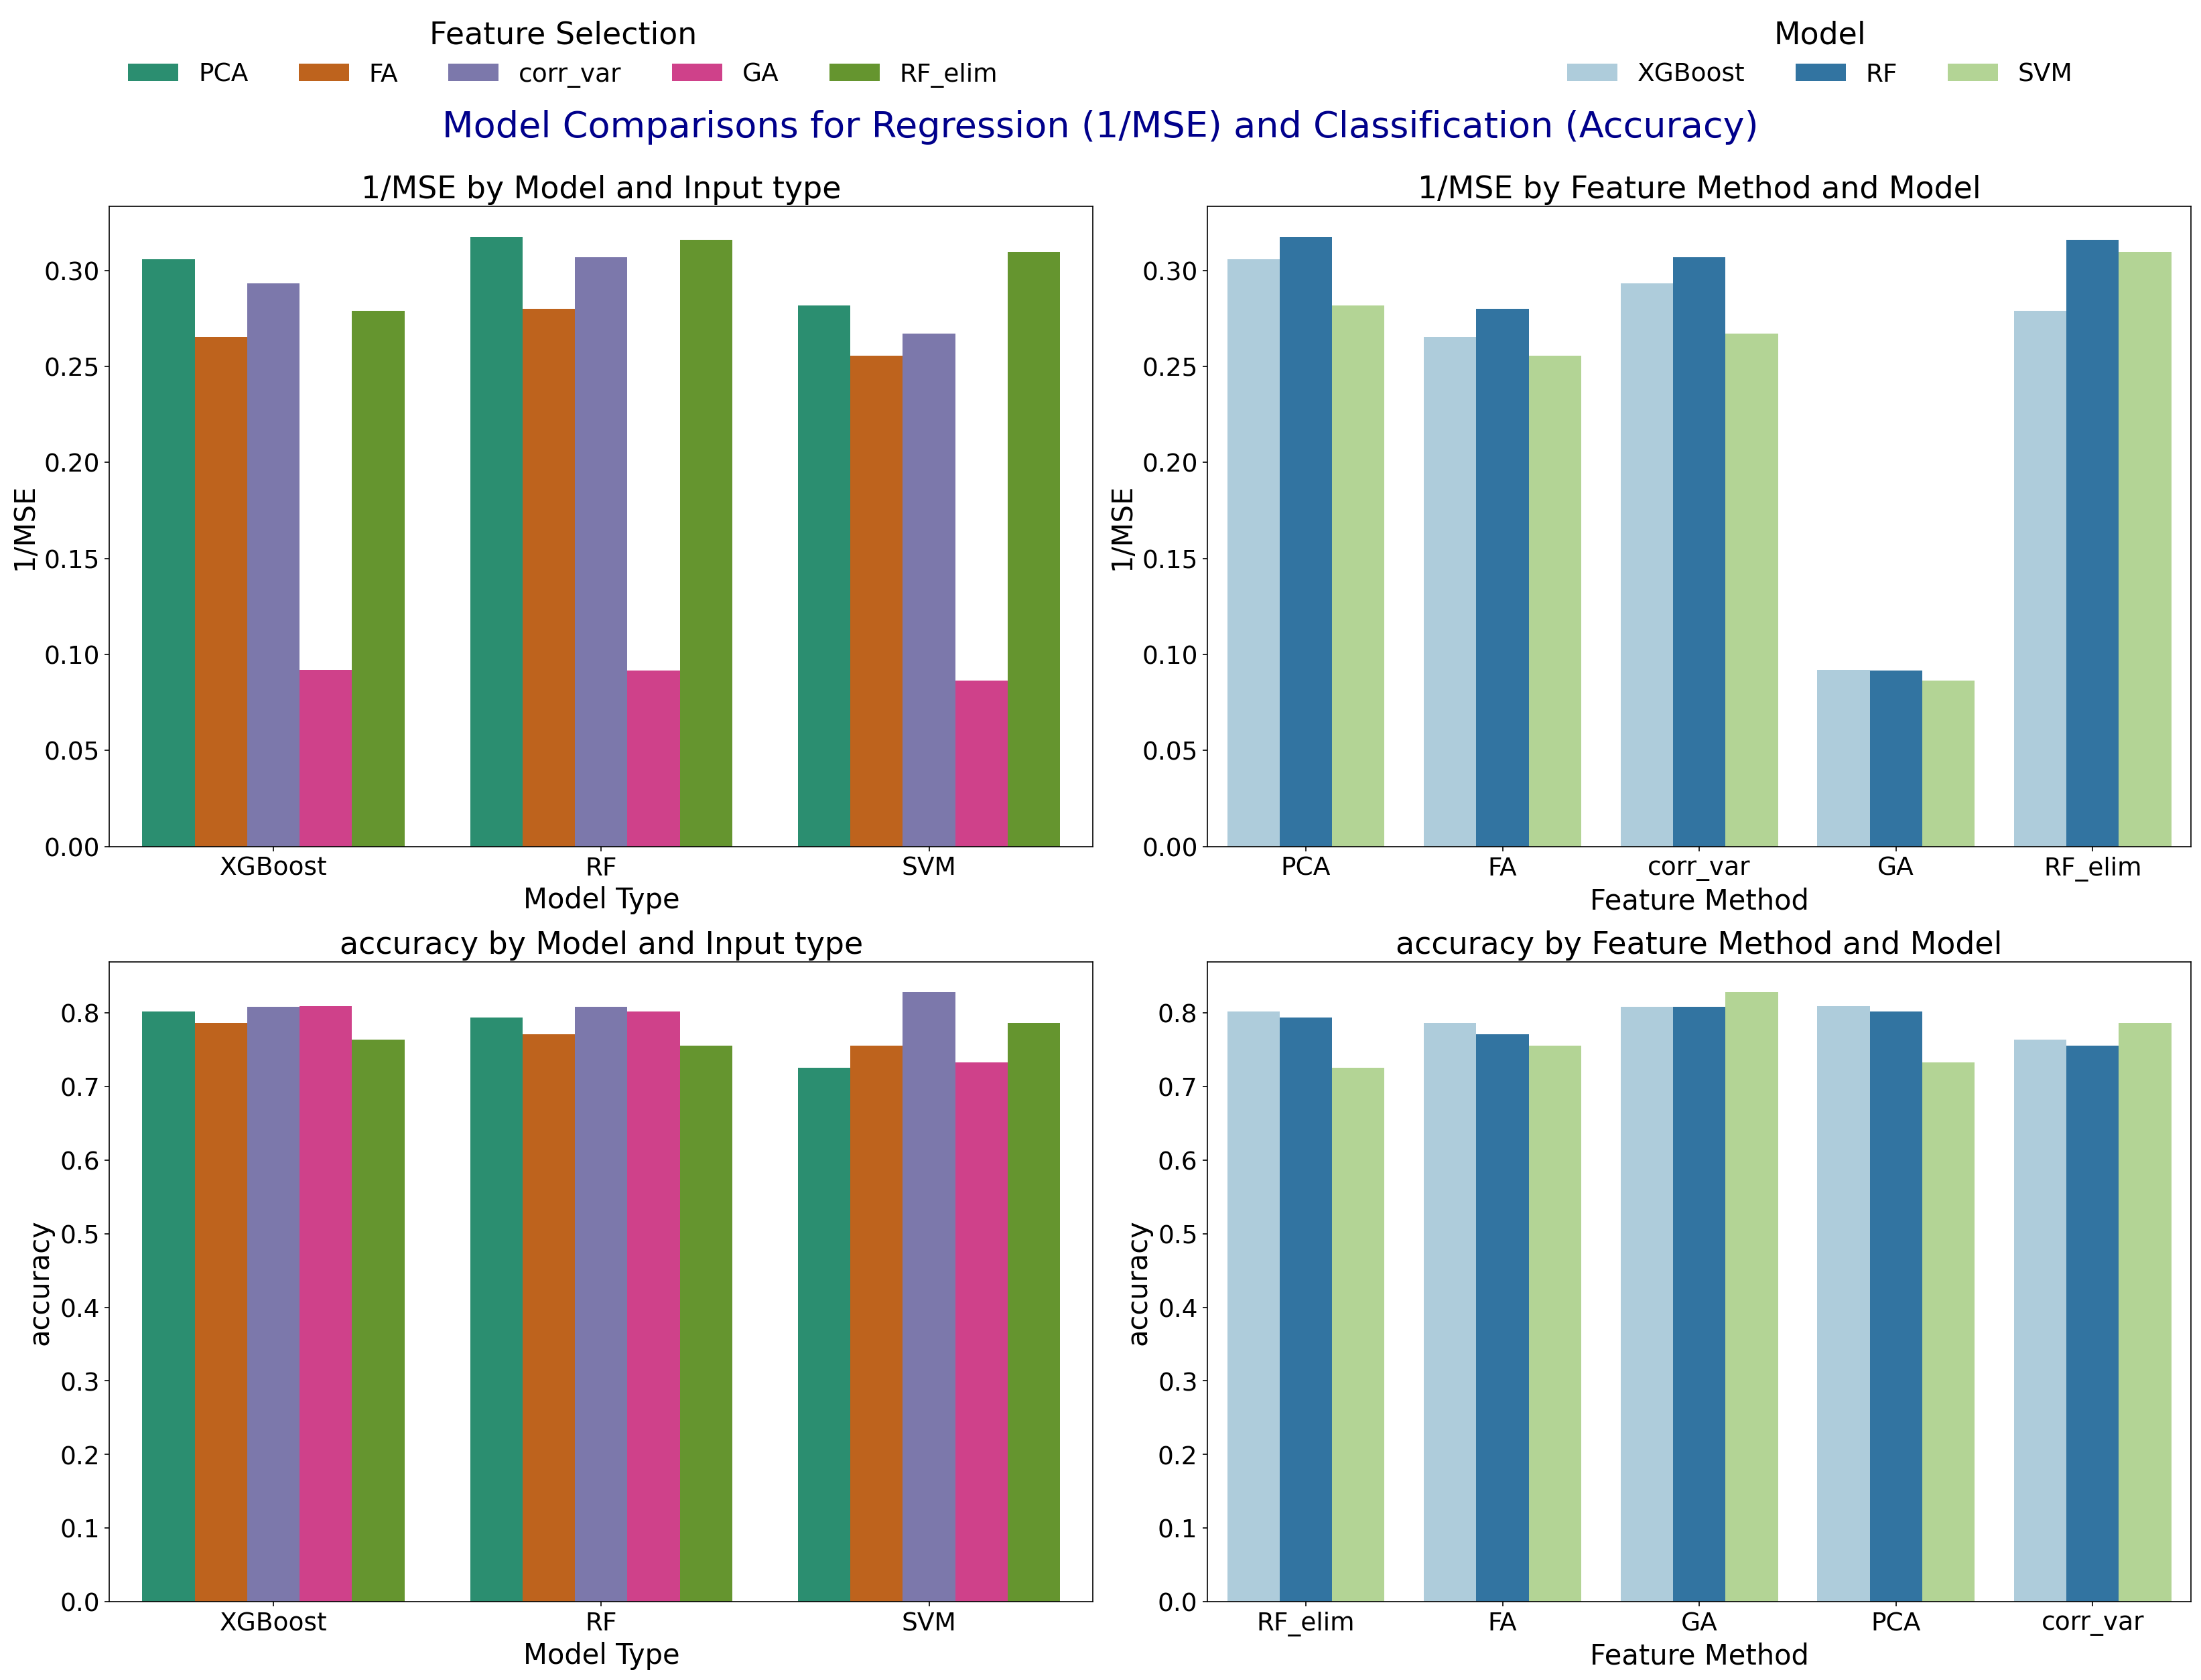

In [6]:
# Invert MSE for regression (higher is better)
reg_metrics['1/MSE'] = 1 / reg_metrics['mse']

# Define Shared Color Palettes
model_palette = sns.color_palette("Paired", len(reg_metrics['model_type'].unique()))
feature_palette = sns.color_palette("Dark2", len(reg_metrics['input_type'].unique()))

# Abbreviation Mapping
abbr_mapping = {
    'random_forest': 'RF',
    'random_forest_elimination': 'RF_elim',
    'Factor_Analysis': 'FA',
    'correlation_variance_filter': 'corr_var',
    'genetic_algorithm': 'GA',
    'PCA': 'PCA'
}

# Abbreviate Labels
reg_metrics['model_type'] = reg_metrics['model_type'].replace(abbr_mapping)
reg_metrics['input_type'] = reg_metrics['input_type'].replace(abbr_mapping)
class_metrics['model_type'] = class_metrics['model_type'].replace(abbr_mapping)
class_metrics['input_type'] = class_metrics['input_type'].replace(abbr_mapping)

# Bar Plot Function
def plot_bar_subplots(df, metric, axes, hue1, hue2, palette1, palette2):
    # Metric per Model by Feature Selection Method
    sns.barplot(data=df, x='model_type', y=metric, hue=hue1, palette=palette1, ax=axes[0])
    axes[0].set_title(f'{metric} by Model and {hue1.replace("_", " ").capitalize()}', fontsize=22)
    axes[0].set_xlabel('Model Type', fontsize=20)
    axes[0].set_ylabel(metric, fontsize=20)
    axes[0].tick_params(axis='x', labelsize=18)
    axes[0].tick_params(axis='y', labelsize=18)
    axes[0].get_legend().remove()

    # Metric per Feature Selection Method across Models
    sns.barplot(data=df, x='input_type', y=metric, hue=hue2, palette=palette2, ax=axes[1])
    axes[1].set_title(f'{metric} by Feature Method and Model', fontsize=22)
    axes[1].set_xlabel('Feature Method', fontsize=20)
    axes[1].set_ylabel(metric, fontsize=20)
    axes[1].tick_params(axis='x', labelsize=18)
    axes[1].tick_params(axis='y', labelsize=18)
    axes[1].get_legend().remove()

# Create Figure and Axes
fig, axes = plt.subplots(2, 2, figsize=(22, 16), sharey=False, dpi=150)

# Plot Regression and Classification Metrics
plot_bar_subplots(reg_metrics, '1/MSE', axes[0], hue1='input_type', hue2='model_type', 
                  palette1=feature_palette, palette2=model_palette)
plot_bar_subplots(class_metrics, 'accuracy', axes[1], hue1='input_type', hue2='model_type', 
                  palette1=feature_palette, palette2=model_palette)

# Define Larger Legend Font
legend_font = {'size': 18}

# Create Legends at the Top
# Feature Selection Legend (Left)
handles1, labels1 = axes[0, 0].get_legend_handles_labels()
fig.legend(handles1, labels1, title="Feature Selection", loc='upper left', 
           bbox_to_anchor=(0.05, 1.05), ncol=5, frameon=False, prop=legend_font, title_fontsize=22)

# Model Type Legend (Right)
handles2, labels2 = axes[0, 1].get_legend_handles_labels()
fig.legend(handles2, labels2, title="Model", loc='upper right', 
           bbox_to_anchor=(0.95, 1.05), ncol=3, frameon=False, prop=legend_font, title_fontsize=22)

plt.suptitle("Model Comparisons for Regression (1/MSE) and Classification (Accuracy)", fontsize=26, color='darkblue')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("model_comparisons_bar_plot.png", dpi=300, bbox_inches='tight')
plt.show()